In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import randint, uniform


In [35]:
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [22]:
import json
import cv2
import items

ModuleNotFoundError: No module named 'items'

## IMPORT & EXPLORE

In [23]:
class KeypointsDataset(Dataset):
    def __init__(self, img_dir, data_file):
        self.img_dir = img_dir
        with open(data_file, "r") as f:
            self.data = json.load(f)
        
        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, idx):
        item = self.data[idx]
        img = cv2.imread(f"{self.img_dir}/{item['id']}.png")
        h, w = img.shape[:2]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(img)

        kps = np.array(item['kps']).flatten()
        kps = kps.astype(np.float32)

        kps[::2] *= 224.0 / w  # Adjust x coordinates
        kps[1::2] *= 224.0 / h  # Adjust y coordinates

        return img, kps

In [25]:
cour_keypoints_dataset_train = KeypointsDataset(img_dir = r"C:\Users\User\Downloads\tennis_court_det_dataset\data\images",
                                                data_file = r"C:\Users\User\Downloads\tennis_court_det_dataset\data\data_train.json" )

cour_keypoints_dataset_val = KeypointsDataset(img_dir = r"C:\Users\User\Downloads\tennis_court_det_dataset\data\images",
                                              data_file = r"C:\Users\User\Downloads\tennis_court_det_dataset\data\data_val.json" )

In [64]:
cour_keypoints_train_dataloader = DataLoader( cour_keypoints_dataset_train, batch_size = 32, drop_last = True )
cour_keypoints_val_dataloader = DataLoader( cour_keypoints_dataset_val, batch_size = 32, drop_last = True )


In [26]:
cour_keypoints_dataset_train.__getitem__(42)

(tensor([[[-1.6898, -1.3473, -1.6384,  ..., -1.3644, -1.4158, -1.5870],
          [-1.3473, -1.2103, -0.9534,  ..., -1.0048, -1.1418, -1.2959],
          [-1.0219, -1.0733, -1.1760,  ..., -1.3302, -1.3130, -1.4500],
          ...,
          [-1.3302, -0.9363, -0.9192,  ..., -1.1418, -1.1247, -1.2103],
          [-1.0733, -0.6452, -0.8678,  ..., -1.1247, -1.1247, -1.2103],
          [-1.3987, -0.9877, -0.7137,  ..., -1.1418, -1.1418, -1.2274]],
 
         [[-1.5105, -1.1604, -1.5105,  ..., -1.3004, -1.3179, -1.4930],
          [-1.1779, -1.0378, -0.8102,  ..., -0.9153, -1.0378, -1.1954],
          [-0.9328, -0.9853, -1.0903,  ..., -1.2304, -1.1779, -1.3179],
          ...,
          [-1.4930, -0.6527, -0.0399,  ..., -0.1099, -0.1450, -0.3025],
          [-1.2479, -0.6001, -0.1275,  ..., -0.1099, -0.1450, -0.3200],
          [-1.4230, -0.9503, -0.0924,  ..., -0.1275, -0.1450, -0.3200]],
 
         [[-1.2990, -0.9504, -1.2816,  ..., -1.1421, -1.1770, -1.3513],
          [-0.9504, -0.7936,

## MODEL BUILD

#### ARCHITECTURE

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [51]:
torch.cuda.get_device_properties()

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3050 Laptop GPU', major=8, minor=6, total_memory=4095MB, multi_processor_count=16, uuid=15678e8c-abb7-821b-a8bf-1798d0455d2e, L2_cache_size=1MB)

In [60]:
efficientnetb0 = models.efficientnet_b0(pretrained = True)

c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
efficientnetb0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [61]:

in_features = efficientnetb0.classifier[1].in_features
efficientnetb0.classifier[1] = torch.nn.Linear(in_features, 14 * 2)

In [62]:
efficientnetb0 = efficientnetb0.to(device)

In [63]:
summary(efficientnetb0, (3,224,224), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

#### TRAINING

In [65]:
optimizer = torch.optim.Adam( efficientnetb0.parameters(), lr=1e-4 )
mse_loss = torch.nn.MSELoss()


train_losses = []
val_losses = []

for epoch in range(25):

    efficientnetb0.train()
    for step, (images, keypoints) in enumerate(cour_keypoints_train_dataloader):

        images = images.to(device)
        keypoints = keypoints.to(device) # Moving to GPU

        optimizer.zero_grad() # Flush gradients
        outputs = efficientnetb0(images) # Get output of a model
        loss = mse_loss( outputs, keypoints ) # Coompute loss 
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        print(f'Epoch {epoch}, Step {step}, Training Loss: {loss.item():.4f}')


    efficientnetb0.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, keypoints in cour_keypoints_val_dataloader:

            images = images.to(device)
            keypoints = keypoints.to(device)
            outputs = efficientnetb0(images)
  
            val_loss_computed = mse_loss( outputs, keypoints )
            val_loss += val_loss_computed.item()
        
        avg_val_loss = val_loss / len(cour_keypoints_val_dataloader)
        val_losses.append(avg_val_loss)
        print(f'--- Epoch {epoch}, Validation Loss: {avg_val_loss:.4f} ---')




          

Epoch 0, Step 0, Training Loss: 14539.4229
Epoch 0, Step 1, Training Loss: 14697.1963
Epoch 0, Step 2, Training Loss: 14865.8057
Epoch 0, Step 3, Training Loss: 14782.2168
Epoch 0, Step 4, Training Loss: 14964.3613
Epoch 0, Step 5, Training Loss: 14315.5166
Epoch 0, Step 6, Training Loss: 14451.6211
Epoch 0, Step 7, Training Loss: 15263.0830
Epoch 0, Step 8, Training Loss: 14649.1250
Epoch 0, Step 9, Training Loss: 14425.1602
Epoch 0, Step 10, Training Loss: 14535.4629
Epoch 0, Step 11, Training Loss: 14626.4434
Epoch 0, Step 12, Training Loss: 14969.0215
Epoch 0, Step 13, Training Loss: 15063.8760
Epoch 0, Step 14, Training Loss: 14574.3652
Epoch 0, Step 15, Training Loss: 14747.5186
Epoch 0, Step 16, Training Loss: 14473.8535
Epoch 0, Step 17, Training Loss: 14578.4316
Epoch 0, Step 18, Training Loss: 14609.2363
Epoch 0, Step 19, Training Loss: 14688.2051
Epoch 0, Step 20, Training Loss: 14740.4824
Epoch 0, Step 21, Training Loss: 15045.3730
Epoch 0, Step 22, Training Loss: 14478.176

In [96]:
#### CONTINUE TRAINING + 25 epoch

for epoch in range(25):

    efficientnetb0.train()
    for step, (images, keypoints) in enumerate(cour_keypoints_train_dataloader):

        images = images.to(device)
        keypoints = keypoints.to(device) # Moving to GPU

        optimizer.zero_grad() # Flush gradients
        outputs = efficientnetb0(images) # Get output of a model
        loss = mse_loss( outputs, keypoints ) # Coompute loss 
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        print(f'Epoch {epoch}, Step {step}, Training Loss: {loss.item():.4f}')


    efficientnetb0.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, keypoints in cour_keypoints_val_dataloader:

            images = images.to(device)
            keypoints = keypoints.to(device)
            outputs = efficientnetb0(images)
  
            val_loss_computed = mse_loss( outputs, keypoints )
            val_loss += val_loss_computed.item()
        
        avg_val_loss = val_loss / len(cour_keypoints_val_dataloader)
        val_losses.append(avg_val_loss)
        print(f'--- Epoch {epoch}, Validation Loss: {avg_val_loss:.4f} ---')



Epoch 0, Step 0, Training Loss: 21.6299
Epoch 0, Step 1, Training Loss: 28.4326
Epoch 0, Step 2, Training Loss: 24.3367
Epoch 0, Step 3, Training Loss: 47.0435
Epoch 0, Step 4, Training Loss: 63.3651
Epoch 0, Step 5, Training Loss: 34.0175
Epoch 0, Step 6, Training Loss: 33.4225
Epoch 0, Step 7, Training Loss: 35.5992
Epoch 0, Step 8, Training Loss: 21.9672
Epoch 0, Step 9, Training Loss: 25.0670
Epoch 0, Step 10, Training Loss: 53.8814
Epoch 0, Step 11, Training Loss: 36.4046
Epoch 0, Step 12, Training Loss: 48.4474
Epoch 0, Step 13, Training Loss: 70.5909
Epoch 0, Step 14, Training Loss: 29.4468
Epoch 0, Step 15, Training Loss: 21.0102
Epoch 0, Step 16, Training Loss: 20.6722
Epoch 0, Step 17, Training Loss: 31.6865
Epoch 0, Step 18, Training Loss: 22.6681
Epoch 0, Step 19, Training Loss: 44.6915
Epoch 0, Step 20, Training Loss: 31.1437
Epoch 0, Step 21, Training Loss: 54.1156
Epoch 0, Step 22, Training Loss: 54.7572
Epoch 0, Step 23, Training Loss: 35.0997
Epoch 0, Step 24, Training

In [69]:

import matplotlib.pyplot as plt 
import seaborn as sns 




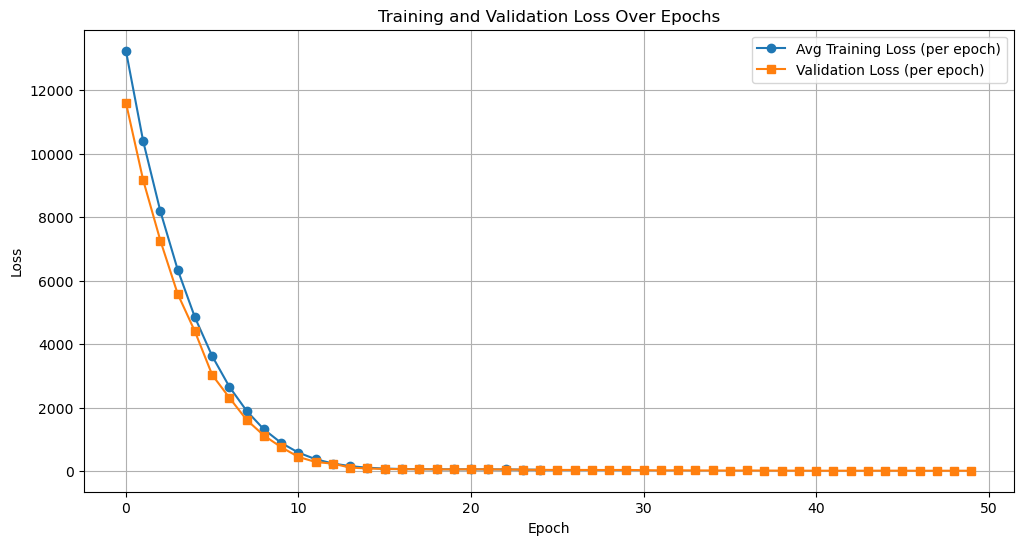

In [97]:
import numpy as np

# Convert step-wise training losses to per-epoch average
steps_per_epoch = len(cour_keypoints_train_dataloader)
train_losses_per_epoch = [
    np.mean(train_losses[i * steps_per_epoch: (i + 1) * steps_per_epoch])
    for i in range(25)
]

plt.figure(figsize=(12, 6))
plt.plot(train_losses_per_epoch, label='Avg Training Loss (per epoch)', marker='o')
plt.plot(val_losses, label='Validation Loss (per epoch)', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


#### TESTING

In [98]:
test_image_path = r"C:\Users\User\Downloads\test_image.jpg"

In [99]:
image = cv2.imread(test_image_path)
images = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]

In [100]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [101]:
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

In [102]:
efficientnetb0.eval()
with torch.no_grad():
    pred = efficientnetb0(input_tensor).cpu().numpy().reshape(-1, 2)  # shape: (14, 2)


pred[:, 0] *= w / 224.0  # x coordinates
pred[:, 1] *= h / 224.0  # y coordinates

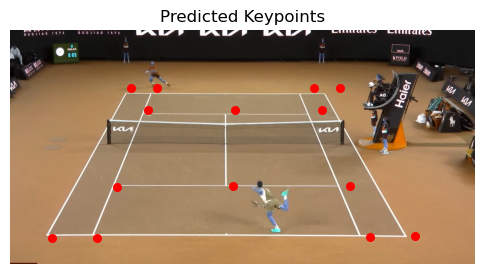

In [103]:
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.scatter(pred[:, 0], pred[:, 1], c='red', s=30)
plt.title('Predicted Keypoints')
plt.axis('off')
plt.show()

In [104]:
# Video path
video_path = r"C:\Users\User\Downloads\tennis_game_sample2.mp4"

# Output video (optional)
output_path = r"C:\Users\User\Desktop\tennis assistant\efficientnet_keypoint_detection\annotated_output.mp4"

# Transformation (same as training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# OpenCV video reader/writer
cap = cv2.VideoCapture(video_path)

# Get video info
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# (Optional) Setup video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Model in eval mode
efficientnetb0.eval()

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    original = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h, w = original.shape[:2]

    # Preprocess
    img_tensor = transform(original).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = efficientnetb0(img_tensor).cpu().numpy().reshape(-1, 2)

    # Scale keypoints to original image
    pred[:, 0] *= w / 224.0
    pred[:, 1] *= h / 224.0

    # Draw keypoints
    for (x, y) in pred.astype(np.int32):
        cv2.circle(frame, (x, y), 4, (0, 0, 255), -1)

    # Write or show
    out.write(frame)  # write to output file
    frame_count += 1

    # Optional: preview in real time (press q to quit)
    cv2.imshow("Keypoints", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Processed {frame_count} frames, saved to {output_path}")

Processed 699 frames, saved to C:\Users\User\Desktop\tennis assistant\efficientnet_keypoint_detection\annotated_output.mp4


In [90]:
device = next(efficientnetb0.parameters()).device
print(f"Model is on: {device}")

Model is on: cuda:0


In [109]:
efficientnetb0 = efficientnetb0.to('cpu')
torch.save(efficientnetb0.state_dict(), r"C:\Users\User\Desktop\tennis assistant\models\efficientnetb0_tennis_court_keypoints.pt")